### 1. Lectura de Dataset

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
import torch
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
path_file = 'sample_data/Combined_Flights_2022.csv'

In [ ]:
df = spark.read.csv(path_file, header=True, sep=",", inferSchema=True)
df.show(5)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

In [ ]:
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 199328
Número de columnas: 61


In [ ]:
#Se visualiza esquema del archivo importado a DataFrame
df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)


### 2. Proceso de limpieza

In [ ]:
#Se eliminan columnas con valores nulos/faltantes
df_clean = df.na.drop()

### 3. Construcción de la muestra a partir de las variables de caracterización.

In [ ]:
#Empaquetado de descriptores y generación de columna de vector con RFormula
#haciendo uso de la variable de caracterización: Airline como objetivo de aprendizaje
#Se generan nuevas columnas: feature  y label (columna de aprendizaje)
from pyspark.ml.feature import RFormula
rForm = RFormula(formula="Airline ~ .")
#Se hace uso del módulo fit para obtener el ensamble
fittedRF = rForm.fit(df_clean)
preparedDF_a = fittedRF.transform(df_clean)
preparedDF_a.show(5)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+--------------------+-----+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime

In [ ]:
#Se visualiza plan de transformación
preparedDF_a.explain()

== Physical Plan ==
*(1) Project [FlightDate#526, Airline#527, Origin#528, Dest#529, Cancelled#530, Diverted#531, CRSDepTime#532, DepTime#533, DepDelayMinutes#534, DepDelay#535, ArrTime#536, ArrDelayMinutes#537, AirTime#538, CRSElapsedTime#539, ActualElapsedTime#540, Distance#541, Year#542, Quarter#543, Month#544, DayofMonth#545, DayOfWeek#546, Marketing_Airline_Network#547, Operated_or_Branded_Code_Share_Partners#548, DOT_ID_Marketing_Airline#549, ... 39 more fields]
+- *(1) Project [FlightDate#526, Airline#527, Origin#528, Dest#529, Cancelled#530, Diverted#531, CRSDepTime#532, DepTime#533, DepDelayMinutes#534, DepDelay#535, ArrTime#536, ArrDelayMinutes#537, AirTime#538, CRSElapsedTime#539, ActualElapsedTime#540, Distance#541, Year#542, Quarter#543, Month#544, DayofMonth#545, DayOfWeek#546, Marketing_Airline_Network#547, Operated_or_Branded_Code_Share_Partners#548, DOT_ID_Marketing_Airline#549, ... 38 more fields]
   +- *(1) Project [FlightDate#526, Airline#527, Origin#528, Dest#529, 

 - **3.1** Se construye muestra representativa bajo muestro estratificado

In [ ]:
#Se genera muestra representativa de la población bajo el muestreo estratificado
# Se añade una nueva columna:stratum que combina los valores de concatenación de las variables de caracterización: Airline y DepDel15
from pyspark.sql.functions import concat, lit
preparedDF_a_stratum = preparedDF_a.withColumn("stratum", concat(preparedDF_a["Airline"], lit("_"), preparedDF_a["DepDel15"]))
preparedDF_a_stratum.show(5)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+--------------------+-----+--------------------+
|FlightDate|             Airline|Origin|Dest|Cancelle

In [ ]:
#Se imprime esquema para visualizar la nueva columna y el tipo de dato
preparedDF_a_stratum.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)


### 4. Fase de experimentación.

Dentro de la **fase de entrenamiento** se realizaran los siguientes pasos


1.   Se generan conjunto de entrenamiento y test para cada k-folds
2.   Proceso de entrenamiento y validación del modelo
3.   Evaluación del módelo


Para lograr estos objetivos se creo una **función** de nombre: **split_train_test**



In [ ]:
# se importan librerias para creación y evaluación del modelo, y creación de k-folds
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import rand, row_number
from pyspark.sql.window import Window

In [ ]:
#se crean listas en donde se almacenaran las metricas de valdiación de cada k-fold entrenado.
metrics_precision = []
metrics_accurancy = []

- **4.1.** Definir un proceso de validación cruzada para medir la variabilidad de los resultados a partir del algoritmo o algoritmos que mejor resultado reportaron en la Actividad 4 del Módulo 5.

Como contexto, para este caso de estudio se tiene dos variables de caracterización y son: DepDel15 y Airline.

La variable de caracterización DepDel15 es de tipo binaria con valor de uno y cero.
La variable de caracterización: Airline es de tipo categórica con cinco valores difentes,  los cuales enuncio a continuación:
1.   Southwest Airlines Co
2.   Mesa Airlines Inc
3.   Air Wisconsin Airlines Corp
4.   GoJet Airlines
5.   Commutair Aka Champlain Enterprises

Dada esta situación y el proceso de generación de la muestra estratificada en el que se creo una variable (stratum) que combina ambas variables de caracterización  para generar estratos representativos, se tomó la decisión de hacer uso de la metrica estadistica: **moda**; lo que significa que para seguir manteniendo una representatividad de los datos en los folds que se construirán,  en cada uno ellos se debe incluir  instacias de datos de la aerolinea que apareció con más frecuecia en la muestra estratificada.

Con respecto a definir el **valor de k**, cabe mencionar que se tiene una alta cantidad de instancias de datos apesar de que previamente se generó  la muestra estratificada, por lo que para eficientar el tiempo de procesamiento, se considera que  **k , tomará el valor de 10,000.** aún así esto representa más de 1hr de procesamiento auqnue también puede depender de otros factores del entorno de ejecución.

In [ ]:
#Se obtiene la métrica:moda a partir del conjunto de datos generados por la muestra estratificada
moda = preparedDF_a_stratum.groupBy("stratum").count().orderBy('count', ascending= False ).first()[ 0 ]
print('Aerolinea que debe aparecer con más frecuencia en los k-folds: ' , moda)

Aerolinea que debe aparecer con más frecuencia en los k-folds:  Southwest Airlines Co._0.0


In [ ]:
'''
División de conjunto de entrenamiento y pruebas,
Entrenar modelo con LogisticRegresion de cada kfold y
Evaluar el modelo con precision y accurancy

Args:
  k_fold : k-fold creado desde la muestra representativa estratificada

 Returns:
    Dos lista que contienen el rendimiento del modelo por
    accuancy: metrics_accurancy y
    precision: metrics_precision

'''

def split_train_test(k_fold):
  k_fold = 1
  metrics_evaluation = []
  print(f"\n--- Creación de conjunto :entrenamiento y test  del k-fold")
  train_data_kfold,test_data_kfold = current_batch_df.randomSplit([0.7,0.3], seed = 42)
  print(f"""Existen {train_data_kfold.count()} instancias en el conjunto train, y {test_data_kfold.count()} en el conjunto test""")
  lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

  print('Entrenando el modelo......')
  modelLR = lr.fit(train_data_kfold)
  params = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 2.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

  #Validación de rendimiento del modelo
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
  presicion = evaluator.evaluate(modelLR.transform(test_data_kfold))
  metrics_precision.append([presicion])
  #metrics_evaluation.append([k_fold,'presicion', presicion])
  print(f"\n--- Métrica: precision de k-fold - : {presicion} ")
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(modelLR.transform(test_data_kfold))
  metrics_accurancy.append([accuracy])
  #metrics_evaluation.append(metrics_accurancy)
  print(f"\n--- Métrica: Accurancy de k-fold - : {accuracy} ")

  return metrics_precision, metrics_accurancy

In [ ]:
#se asigna valor a k
k = 10000
total_rows = preparedDF_a_stratum.count()

window_spec = Window.orderBy(rand())

# Se añade un id como identificador a los registros
df_with_id = preparedDF_a_stratum.withColumn("id", row_number().over(window_spec))

# Se calcula el numero de batches que se pueden generar
num_batches = (total_rows + k - 1) // k

print(f"Total rows: {total_rows}")
print(f"Batch size (k): {k}")
print(f"Number of batches: {num_batches}")

# se inicializa un array para almacenar la media de cada submuestra que se genera
# por iteración
statistics_mode = []
precision_metrics = []
accuracy_metrics = []


# se obtiene el primer batch
batch_union_df = df_with_id.filter(f"id >= 0 AND id < {k}").drop("id")

# Se seleccionan solo tres atributos o desriptores a trabajar para este ejemplo
batch_union_df.describe(['stratum']).show()
# Se almacena la estadistica del primer batch
statistics_mode.append([batch_union_df.groupBy("stratum").count().orderBy('count', ascending= False ).first()[ 0 ], batch_union_df.count()])

for batch_num in range(1, num_batches):
    start_id = batch_num * k
    end_id = min((batch_num + 1) * k, total_rows)

    # Se obtiene el batch correspondiente a la iteracion
    current_batch_df = df_with_id.filter(f"id >= {start_id} AND id < {end_id}").drop("id")

    #Se invoca función para generar conjunto de entrenamiento y test de cada kfold y así generar las métricas de evaluación
    #que son: Accurancy y presicion.
    split_train_test(current_batch_df)

    # Se agrega el batch al batch que se construye
    batch_union_df = batch_union_df.union(current_batch_df)

    print(f"\n--- Processing Batch {batch_num + 1}/{num_batches} (Rows {start_id} to {end_id-1}) ---")

    # Se guardan estadisticas de la submuestra acumulativa
    statistics_mode.append([batch_union_df.groupBy("stratum").count().orderBy('count', ascending= False ).first()[ 0 ], batch_union_df.count()])

    # Se imprime información estadística del batch
    batch_union_df.describe(['stratum']).show()


Total rows: 195310
Batch size (k): 10000
Number of batches: 20
+-------+--------------------+
|summary|             stratum|
+-------+--------------------+
|  count|                9999|
|   mean|                null|
| stddev|                null|
|    min|Air Wisconsin Air...|
|    max|Southwest Airline...|
+-------+--------------------+


--- Creación de conjunto :entrenamiento y test  del k-fold
Existen 7104 instancias en el conjunto train, y 2896 en el conjunto test
Entrenando el modelo......

--- Métrica: precision de k-fold - 1: 0.9982773606014843 

--- Métrica: Accurancy de k-fold - 1: 0.99896408839779 

--- Processing Batch 2/20 (Rows 10000 to 19999) ---
+-------+--------------------+
|summary|             stratum|
+-------+--------------------+
|  count|               19999|
|   mean|                null|
| stddev|                null|
|    min|Air Wisconsin Air...|
|    max|Southwest Airline...|
+-------+--------------------+


--- Creación de conjunto :entrenamiento y test 

### 5.  Visualización de resultados.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#se obtiene el eje x de las metricas: accurancy y precision, considerando la cantidad del kfold, generados
#y entrenados
x_metrics_precision=len(metrics_precision)
x_metrics_accurancy =len(metrics_accurancy)

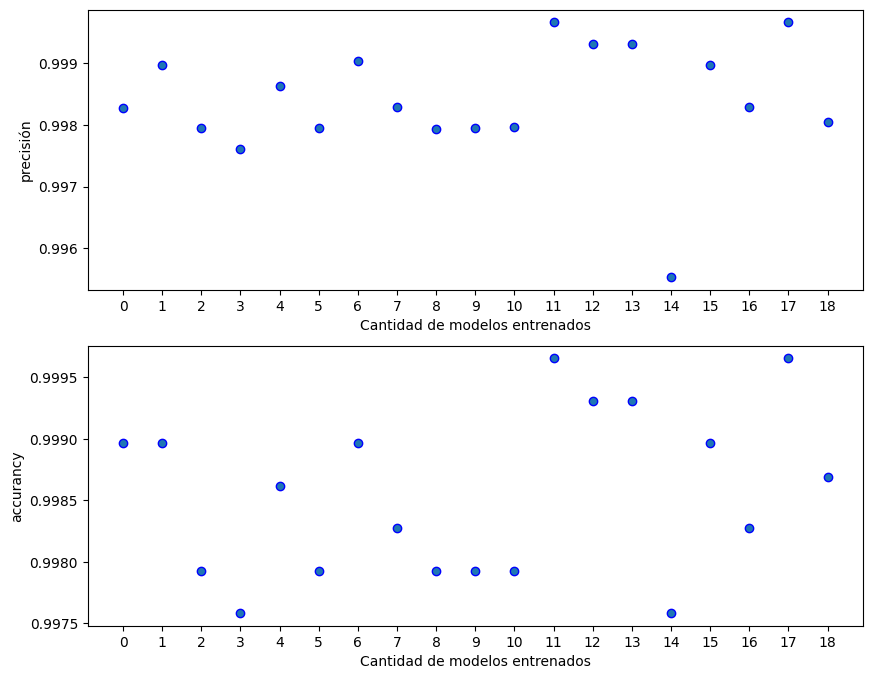

In [ ]:
# Gráfica de resultados de la etapa de entrenamiento de cada K-fold
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].scatter(
    x = np.arange(0, x_metrics_precision),
    y = metrics_precision,
    marker    = 'o',
    edgecolor = 'blue',
)

ax[0].set_xlabel('Cantidad de modelos entrenados')
ax[0].set_ylabel('precisión')
#se modifica escala de eje x para mejor representación
ax[0].set_xticks(np.arange(0, x_metrics_precision, step=1))


ax[1].scatter(
    x = np.arange(0, x_metrics_accurancy),
    y = metrics_accurancy,
    marker    = 'o',
    edgecolor = 'blue',
)

ax[1].set_xlabel('Cantidad de modelos entrenados')
ax[1].set_ylabel('accurancy')
#se modifica escala 1 de eje x para mejor representación
ax[1].set_xticks(np.arange(0, x_metrics_accurancy, step=1))

Text(0.5, 1.0, 'Moda del atributo stratum')

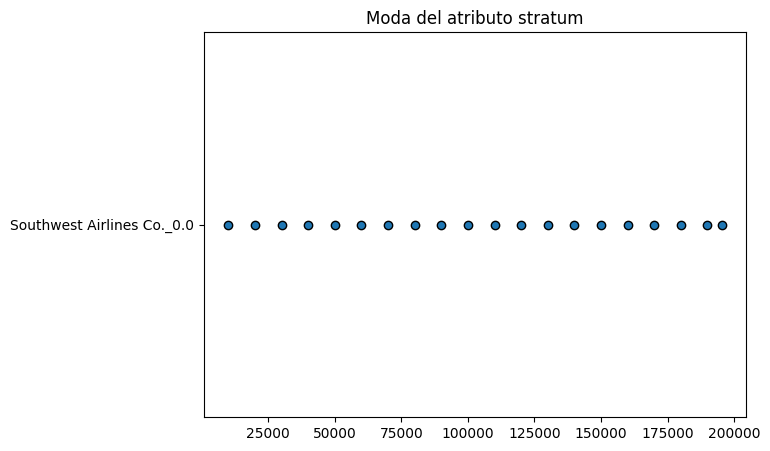

In [ ]:
# Importar libreria de visualización
import matplotlib.pyplot as plt

# Grafica el comportamiento de la variaciones de la moda, como medida de estabilidad de la muestra de los k-folds
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    x = [t[1] for t in statistics_mode],
    y = [t[0] for t in statistics_mode],
    marker    = 'o',
    edgecolor = 'black',
    label= f"stratum,"
)
ax.set_title('Moda del atributo stratum')

### 6. Discusión de resultados y Conclusiones

*   Con base a los resultados obtenidos del proceso de creación de kfolds para el cual se determino la moda como medida de representatividad; se logro que persisistiera la aerolinea con más frecuecia(mode) en cada kfolds.
*   El rendimiento del modelo en general fue bastante bueno, con base a los resultados de las metricas: **accurancy** 0.997 valor mínimo  y 0.999 valor máximo; para la metrica de evaluación **presicion**, el valor mínimo fue: 0.995 y valor máximo: 0.999 estos datos se representan en la gráfica :" # **Gráfica de resultados de la etapa de entrenamiento de cada K-fold**."
*   Con respecto a la variación de la moda en cada k-fold se mantiene de manera constante y es entendible ya que al ser una variable categorica con un valor binario, sólo se puede obtener información de frecuencia, se representa en la gráfica **"Grafica el comportamiento de la variaciones de la moda, como medida de estabilidad de la muestra de los k-folds"**
*   Generar una muestra representativa y entrenar cada kfold con el modelo LinearRegression conlleva bastante tiempo de computo, por lo que un pequeño error conlleva a reejecutar todo el proceso, lo que incrementa el tiempo de trabajo y procesamiento.

